# Opimisation thèse Manon

### Import des librairies

In [33]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import typing as ty
from collections.abc import Callable
from mpl_toolkits.mplot3d import axes3d

#Custom type hints
Vector = npt.NDArray[np.float64] # Column vector (n,1)
VectorArray = npt.NDArray[np.float64] # Array (n,N)
Matrix = npt.NDArray[np.float64] # Array (n,n)

## Custom plot 3D

In [42]:
def comparaison3DPlot(function_to_plot: Callable[[VectorArray],float], domain: list[Matrix], function_constrain: Callable[[VectorArray],float]=None, points: VectorArray=None):
    """
    Affichage comparatif (3D et projeté dans le plan) d'une fonction avec affichage de la contrainte et de points si besoin.
    
    La contrainte est respectée si la fonction est positive;
    Le domain (domain) est sous la forme d'une meshgrid;
    """
    # Création de l'espace figure
    fig = plt.figure(figsize=plt.figaspect(0.45),layout='constrained')
    fig.suptitle("Etat de l'optimisation")
    
    # Plot 3D et 2D
    ax3D = fig.add_subplot(1, 2, 2, projection='3d')
    ax2D = fig.add_subplot(1, 2, 1)
    X, Y = domain
    
    # coût
    Zcout = np.zeros(X.shape)
    miniCout, maxiCout = [0,0]
    for indx in range(Zcout.shape[0]):
        for indy in range(Zcout.shape[1]):
            Zcout[indx,indy] = function_to_plot(np.array([[X[indx,indy]], [Y[indx,indy]]]))
    surfCout = ax3D.plot_surface(X, Y, Zcout, rstride=1, cstride=1, linewidth=0, antialiased=True, color="purple", alpha=0.6, label="coût")
    flatCout = ax2D.pcolormesh(X, Y, Zcout, cmap="plasma")
    
    # contrainte
    if not(function_constrain is None):
        Zcont = np.zeros(X.shape)
        for indx in range(Zcont.shape[0]):
            for indy in range(Zcont.shape[1]):
                Zcont[indx,indy] = function_constrain(np.array([[X[indx,indy]], [Y[indx,indy]]]))
        flatCont = ax2D.contour(X,Y,Zcont,levels=[0.])
        contour3DCont = ax3D.contourf(X,Y,Zcont,levels=[np.min(Zcont),0.,np.max(Zcont)],offset=-np.min(Zcout),alpha=0.7)
        
    # points
    if not(points is None):
        points_2D_2D = ax2D.plot(points[0,:], points[1,:], color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], np.zeros(points[0,:].shape)-np.min(Zcout), color="red", marker="x", label="points")
        points_2D_3D = ax3D.plot(points[0,:], points[1,:], function_to_plot(points), color="orange", marker="x", label="points")
        
    # Cosmétique
    ax3D.grid(True)
    ax3D.set_xlabel('x1')
    ax3D.set_ylabel('x2')
    ax3D.set_zlabel('z')
    ax3D.set_zlim([np.min(Zcout),np.max(Zcout)])
    ax3D.legend()
    ax2D.clabel(flatCont, fmt="contrainte")
    ax2D.legend()
    ax2D.grid(True)
    ax2D.set_xlabel('x1')
    ax2D.set_ylabel('x2')
    fig.colorbar(flatCout, ax=ax2D, label="coût")
    fig.colorbar(contour3DCont, ax=ax3D, label="contrainte")
    
    plt.show()

#### Exemple de plot

/tmp/ipykernel_78/4209972993.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Zcout[indx,indy] = function_to_plot(np.array([[X[indx,indy]], [Y[indx,indy]]]))
/tmp/ipykernel_78/4209972993.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Zcont[indx,indy] = function_constrain(np.array([[X[indx,indy]], [Y[indx,indy]]]))


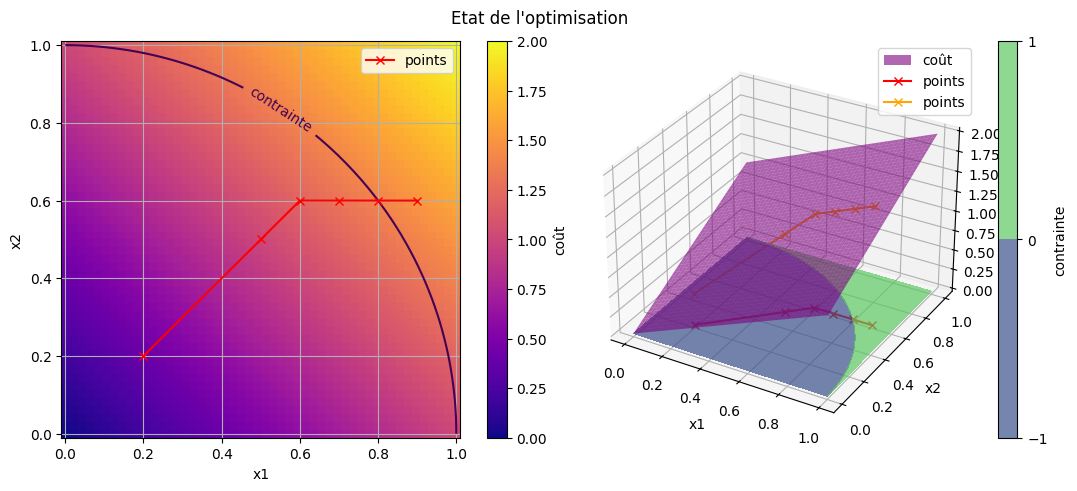

In [43]:
f = lambda points: points[0,:]+points[1,:]
h = lambda points: points[0,:]**2+points[1,:]**2-1

Xdomain = np.linspace(0,1)
X,Y = np.meshgrid(Xdomain,Xdomain)
points = np.array([[0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                   [0.2, 0.5, 0.6, 0.6, 0.6, 0.6]])
        
comparaison3DPlot(f,[X,Y],h, points)

## Présentation du problème

#### Définition mathématique du problème

On souhaite résoudre le problème suivant :
$$
    \min_{x\in K} f(x), \quad \text{with } K=\{x\in(\mathbb{R}_+^*)^n \vert h(x)\geq 0\}.
$$
Avec :
$$
    f(x)=\sum_{i=1}^n x_i, \quad h(x)=\text{Module de stabilité de la matrice }A(x).
$$

### Définitions basiques

#### Elements utiles

In [19]:
# Matrice D (points du graph)
D12=1.4
D21=0.8
D13 = 0.8
D31 = 0.2
D32 = 0.6
D23 = 0.5

D = np.array([[-D21-D31,D12,D13],
              [D21,-D12-D32,D23],
              [D31,D32,-D13-D23]])
# D42 = 0; D52 = 0; D24 = 0; D25=0;D43=0;D53=0;D34=0;D35=0

# Constantes et fonctions
n = np.shape(D)[0] 
I = np.eye(n)
geneGFonc = lambda a,K: lambda x: a-x/K

#### Matrice A(x)

In [20]:
g1= geneGFonc(0.7, 2)
g2= geneGFonc(0.5, 3)
g3= geneGFonc(0.2, 4)

def A(x: Vector) -> Matrix:
    x1 = x[0,0]
    x2 = x[0,1]
    return np.diag([g1(0)-x1,g2(0)-x2,g3(0)]) +D

#### Module de stabilité (contrainte)

In [21]:
def h(x: Vector) -> float:
    eigv, eigp = np.linalg.eig(A(x))
    real = eigv.real
    return max(real)

#### Coût et affichage

In [ ]:
def f(x):
    